In [5]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, OneSidedSelection
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')


資料預處理

In [6]:
from sklearn.preprocessing import LabelEncoder as LE
train_path = './TraData.csv'
data = pd.read_csv(train_path, sep=',') # .sample(20000) # toy

# 只選 adx, spaceType, spaceId, ip, 因為只有這四組 feature 對 click 的影響是顯著的
del data['spaceCat']
del data['adType']
del data['os']
del data['deviceType']
del data['publisherId']
del data['dclkVerticals']
# del data['campaignId']
del data['advertiserId']

# data.drop_duplicates(inplace=True)

print 'Total %d rows.'%len(data)

label = data.click
del data['click'] # 記得別讓答案變成一組 feature ，這樣 model 就直接看到答案了

le_list = {}
for key, value in data.iteritems():
    le_list[key] = LE()
    data[key] = le_list[key].fit_transform(value) ## csv 檔中 feature 均為屬性資料
print data.sample(3) ## 印出三筆資料觀察




Total 961457 rows.
        adx  spaceType  spaceId      ip  campaignId
155389    1          1       45  491427          39
650560    1          1      196  241586          30
865492    1          1      129  131397          29


設定模型參數、建構模型

In [7]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
rus = OneSidedSelection()
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
param = {
    'objective': 'binary:logistic', # 二元分類的問題
    #'gamma': 0.2,                   # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子。 0.2
    'max_depth': 7,                 # 構建樹的深度，越大越容易過擬合 5
    #'reg_lambda': 2.2,              # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
    'subsample': 0.9,               # 隨機取樣訓練樣本
    'colsample_bytree': 0.9,        # 生成樹時進行的列取樣
    'silent': 0,                    # 設定成 0 輸出 log 到 stderr
    'learning_rate': 0.01,          # 學習率
    #'seed': 1000,
    'scale_pos_weight': 16,         # 給正樣本的權重
    'nthread': 4,                   # cpu 執行緒數
    'n_estimators': 30             # 生幾棵樹
}
for train, test in kfold.split(data, label):
    X, y = rus.fit_sample(data.iloc[train], label.iloc[train])
    print 'Total %d rows'%len(X)
    bst = xgb.XGBClassifier(**param)
    bst.fit(X,y,eval_metric='auc')
    pred = np.asarray(bst.predict(np.asarray(data.iloc[test])))
    pred[pred<0.5] = 0
    pred[pred>0] = 1
    score = f1_score(label.iloc[test], pred)
    print 'score: %.2f%%'%(score*100.)
    cvscores.append(score)
print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(cvscores)*100., np.std(cvscores)*100.)) ## validation 的 f1-score 的平均值 +/- 兩倍標準差

Total 863735 rows
score: 16.67%
Total 863670 rows
score: 16.06%
Total 864150 rows
score: 11.19%
Total 864521 rows
score: 14.88%
Total 864277 rows
score: 6.56%
Total 862211 rows
score: 5.61%
Total 863285 rows
score: 10.71%
Total 861479 rows
score: 14.49%
Total 862468 rows
score: 9.60%
Total 864359 rows
score: 17.05%
f1.avg: 12.2816% (+/- 3.9502%)


In [8]:
## DT on sklearn is based on CART algorithm. Let's try ID3&CART algorithm both. And SVM.
class_weight = {0:1, 1:16}
classifiers = {
               'DT_CART_opt':tree.DecisionTreeClassifier(class_weight=class_weight, max_depth=7), 'RF_CART_opt':RandomForestClassifier(class_weight=class_weight, max_depth=7),
               'BoostDT_CART_opt':AdaBoostClassifier(tree.DecisionTreeClassifier(class_weight=class_weight, max_depth=7), n_estimators=30),
               'DT_ID3':tree.DecisionTreeClassifier(criterion="entropy",class_weight=class_weight, max_depth=7), 'RF_ID3':RandomForestClassifier(criterion="entropy",class_weight=class_weight, max_depth=7),
               'BoostDT_ID3':AdaBoostClassifier(tree.DecisionTreeClassifier(criterion="entropy",class_weight=class_weight, max_depth=7), n_estimators=30),
               #'Random':DummyClassifier('uniform'), ## 下面這兩個是 baseline ，不應該比亂猜/都猜0還差
               #'Guess0':DummyClassifier('most_frequent')
              }

3-fold Cross-validation

In [9]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
for model_name, model in classifiers.items():
    print('Training %s...'%model_name)
    cvscores = []
    for train, test in kfold.split(data, label):
        X, y = rus.fit_sample(data.iloc[train], label.iloc[train])
        print 'Total %d rows'%len(X)
        model.fit(X,y)
        pred = np.asarray(model.predict(np.asarray(data.iloc[test])))
        pred[pred<0.5] = 0
        pred[pred>0] = 1
        score = f1_score(label.iloc[test], pred)
        print 'score: %.2f%%'%(score*100.)
        cvscores.append(score)
    print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(cvscores)*100., np.std(cvscores)*100.)) ## validation 的 f1-score 的平均值 +/- 兩倍標準差

Training DT_CART_opt...
Total 637609 rows
score: 12.52%
Total 638722 rows
score: 12.36%
Total 638664 rows
score: 11.65%
f1.avg: 12.1762% (+/- 0.3800%)
Training BoostDT_ID3...
Total 639379 rows
score: 5.95%
Total 638468 rows
score: 5.99%
Total 639712 rows
score: 9.41%
f1.avg: 7.1152% (+/- 1.6240%)
Training RF_ID3...
Total 639510 rows
score: 12.57%
Total 639257 rows
score: 8.38%
Total 639631 rows
score: 10.81%
f1.avg: 10.5874% (+/- 1.7185%)
Training RF_CART_opt...
Total 640270 rows
score: 0.99%
Total 638673 rows


/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


score: 0.00%
Total 639948 rows
score: 1.79%
f1.avg: 0.9279% (+/- 0.7336%)
Training DT_ID3...
Total 639959 rows
score: 10.22%
Total 639859 rows
score: 11.28%
Total 639017 rows
score: 12.05%
f1.avg: 11.1840% (+/- 0.7498%)
Training BoostDT_CART_opt...
Total 640199 rows
score: 4.42%
Total 637673 rows
score: 3.64%
Total 638512 rows
score: 2.89%
f1.avg: 3.6476% (+/- 0.6231%)


In [13]:
from sklearn.model_selection import train_test_split
param = {
    'objective': 'binary:logistic', # 二元分類的問題
    #'gamma': 0.2,                   # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子。 0.2
    'max_depth': 7,                 # 構建樹的深度，越大越容易過擬合 5
    #'reg_lambda': 2.2,              # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
    'subsample': 0.9,               # 隨機取樣訓練樣本
    'colsample_bytree': 0.9,        # 生成樹時進行的列取樣
    'silent': 0,                    # 設定成 0 輸出 log 到 stderr
    'learning_rate': 0.01,          # 學習率
    #'seed': 1000,
    'scale_pos_weight': 16,         # 給正樣本的權重
    'nthread': 4,                   # cpu 執行緒數
    'n_estimators': 200             # 生幾棵樹
}
clf = xgb.XGBClassifier(**param)
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.1)
X_train, Y_train = rus.fit_sample(X_train, Y_train)
clf.fit(X_train, Y_train)
predicted = np.asarray(clf.predict(np.asarray(X_test)))
predicted[predicted<0.5] = 0
predicted[predicted>0] = 1
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
score = f1_score(Y_test, predicted)
print confusion_metrix
print inclass_precision
print score

import pickle

with open("xgboost_model.pickle.dat", "wb") as fp:
    pickle.dump(clf, fp)
with open("xgboost_model.pickle.dat", "rb") as fp:
    clf_retrived = pickle.load(fp)

[[96028    58]
 [   49    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96086
          1       0.16      0.18      0.17        60

avg / total       1.00      1.00      1.00     96146

0.170542635659


In [14]:
predicted = np.asarray(clf_retrived.predict(np.asarray(X_test)))
predicted[predicted<0.5] = 0
predicted[predicted>0] = 1
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
score = f1_score(Y_test, predicted)
print confusion_metrix
print inclass_precision
print score
del clf_retrived

[[96028    58]
 [   49    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96086
          1       0.16      0.18      0.17        60

avg / total       1.00      1.00      1.00     96146

0.170542635659


PCA 降維、可視化

In [15]:
def plot_embedding(x_emb,y,n,title=''): ## visualization
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [16]:
pcavis = PCA(n_components=2)
embedding = pcavis.fit_transform(X_test)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


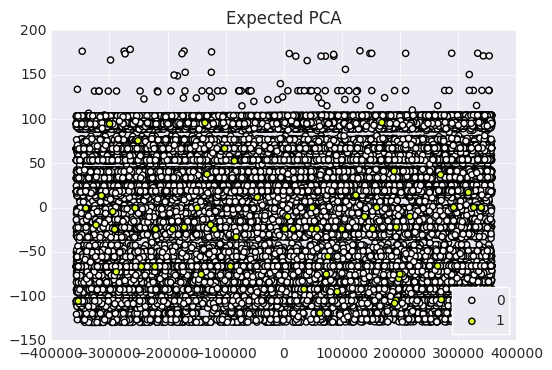

In [17]:
plot_embedding(embedding, Y_test, 2, 'Expected PCA') ## 視覺化, 看起來幾乎不是線性可分的

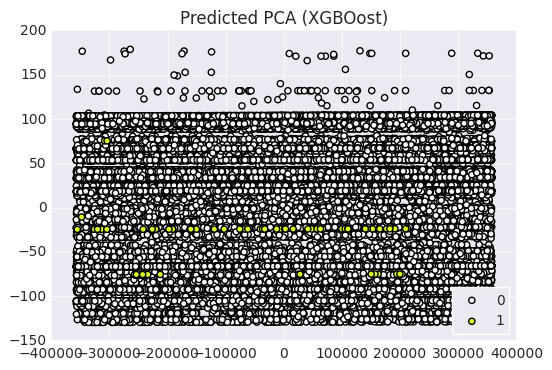

[[96028    58]
 [   49    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96086
          1       0.16      0.18      0.17        60

avg / total       1.00      1.00      1.00     96146



In [21]:
predicted = clf.predict(np.asarray(X_test))
predicted[predicted<0.5] = 0
predicted[predicted>0] = 1
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
plot_embedding(embedding, predicted, 2, 'Predicted PCA (XGBOost)')
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
print confusion_metrix   ## 看看 model 在未知的資料上表現如何，判斷模型是否 underlearning, 注意，我們只在乎 label==1 的部分
print inclass_precision  ## 同上

看來挺糟糕的 :\

補充從 R script 得到的這份 training data 的 ANOVA 結果（從九十萬筆資料隨機抽樣5000筆資料）：

```R
               Df Sum Sq  Mean Sq   F value Pr(>F)    
adx             1  0.000 0.000003 2.192e+23 <2e-16 ***
spaceType       1  0.000 0.000011 9.356e+23 <2e-16 ***
spaceId       128  0.516 0.004034 3.451e+26 <2e-16 ***
ip           4839  3.480 0.000719 6.154e+25 <2e-16 ***
os              3  0.000 0.000000 2.000e-03 0.9999    
campaignId      1  0.000 0.000000 3.089e+00 0.0911 .  
advertiserId    1  0.000 0.000000 1.496e+00 0.2327    
Residuals      25  0.000 0.000000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

可以看出 adx, spaceType, spaceId, ip 對 click 的影響似乎是顯著的？

也許可以實驗看看只選擇 adx, spaceType, spaceId, ip 當作 feature？或是使用 PCA 做降維？

因為他們對 click 的影響較顯著？ p<0.05